## 1. 異常檢測 - KNN
- 經典強大KNN，用於非監督式方法[參考](https://towardsdatascience.com/k-nearest-neighbors-knn-for-anomaly-detection-fdf8ee160d13#:~:text=kNN%20is%20a%20supervised%20ML,systems%2C%20face%20detection%20applications%20etc.)
- 原理: 其核心概念其實就是相似性(距離)衡量，大多數的異常檢測也都包含了這個核心概念。

---
2023-01

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors  # 非監督用
from sklearn.datasets import load_iris

C:\Users\aaronyang\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
data = pd.DataFrame(load_iris()['data'], columns=load_iris()['feature_names'])

## 輸入數據
df = data[["sepal length (cm)", "sepal width (cm)"]]
df.columns = ["sepal_length", "sepal_width"]

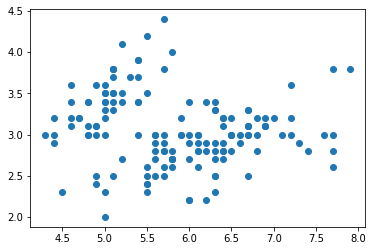

In [3]:
plt.scatter(df["sepal_length"], df["sepal_width"])

In [4]:
## 創建數組
X = df.values

In [5]:
X.shape

(150, 2)

In [6]:
# 實例化模型
nbrs = NearestNeighbors(n_neighbors = 3)
# 擬合模型
nbrs.fit(X)

NearestNeighbors(n_neighbors=3)

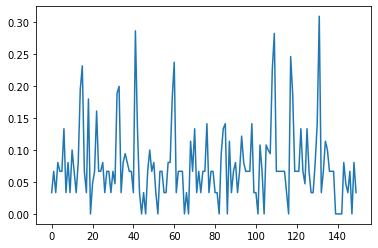

In [7]:
# k-neaighbors 與模型輸出的距離和索引
distances, indexes = nbrs.kneighbors(X)
# 繪製每個觀測值的 k 距離的平均值
plt.plot(distances.mean(axis =1))

> 由上圖可以看到每個點與其他點的平均距離，所以如果值特別大，就代表`該點`非常孤立，可能為異常的值，
> 這個方法非常直覺與好控制，解釋上也非常容易，當然需要去設定 threshold 來判斷，因此需要一些EDA探索。

In [8]:
## 直觀地確定截止值 > 0.15 


threshold = 0.15

outlier_index = np.where(distances.mean(axis = 1) > threshold) 
outlier_index

(array([ 14,  15,  18,  22,  32,  33,  41,  59,  60, 108, 109, 117, 118,
        131], dtype=int64),)

In [9]:
## 過濾異常值
outlier_values = df.iloc[outlier_index] 
outlier_values

,sepal_length,sepal_width
14,5.8,4.0
15,5.7,4.4
18,5.7,3.8
22,4.6,3.6
32,5.2,4.1
33,5.5,4.2
41,4.5,2.3
59,5.2,2.7
60,5.0,2.0
108,6.7,2.5


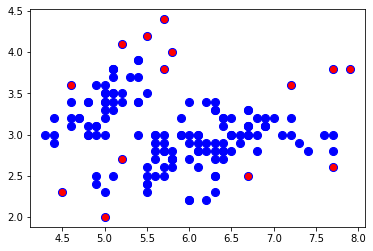

In [10]:
# 繪製數據
plt.scatter(df["sepal_length"], df["sepal_width"], color = "b", s = 65)
# 繪製異常值
plt.scatter(outlier_values["sepal_length"], outlier_values["sepal_width"], color = "r")

> 可以看到異常值就可以被標示出來，不過需要注意的是視覺化也通常需要降維到2維才有機會。

## 2. Isolation Forest
- 原理: 是一個強大的非監督式機器學習模型，如同decision tree一樣，透過隨機選擇特徵以及threshold去分類樣本，只不過，判斷是否為異常是透過，如果那個葉節點(最終但一個樣本)，每次都深度很淺，代表它周圍並沒有類似的樣本，很有可能就是異常值。
- 尤其適合在高維資料中使用。

---
2023-02-03

In [11]:
from sklearn.ensemble import IsolationForest

In [12]:
## 建立模型，可以看到模型就不會有max_depth等參數，因為就是故意要分到每一個樣本都是葉節點！

iso_forest = IsolationForest(n_estimators=100, random_state=222, warm_start=True)
iso_pred = iso_forest.fit_predict(X)
iso_pred

array([ 1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1,
        1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [13]:
## 將異常-1與正常挑出來並透過scatter畫出來看看

normal_index = np.where(iso_pred == 1)
anomaly_index = np.where(iso_pred == -1)

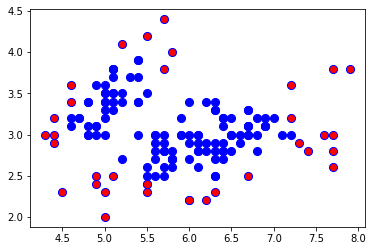

In [14]:
# 繪製全部數據
plt.scatter(df["sepal_length"], df["sepal_width"], color = "b", s = 65)
# 繪製異常值
plt.scatter(df.iloc[anomaly_index]['sepal_length'], df.iloc[anomaly_index]["sepal_width"], color = "r")

> 可以看到因為它的概念關係，在核心區的(中心)會比較難以區分開來，所以深度會較深，會比較是`normal`；而較邊緣的點則因為容易區分，比較容易是`anomaly`

## [3. Local Outlier Factor](https://scikit-learn.org/stable/modules/outlier_detection.html#overview-of-outlier-detection-methods)

- 原理: 透過檢驗目標點x與附近鄰居(距離近)的點之密度差異，如果該目標點x密度明顯小於鄰居點，
    則被判定為 outlier，局部密度是透過knn取得，也就是k個最近鄰居，會去計算一個叫做 `LOF score`的分數，
    `LOF score` = K個鄰居的密度與自身的比值，越大代表越容易是異常值，一般來說k=20可以表現得不錯。
    如果異常值比例比較高，則需要調高k。
    
- 適合用於高維資料

---
2023-02-04

In [15]:
from sklearn.neighbors import LocalOutlierFactor

In [16]:
lof = LocalOutlierFactor(n_neighbors=20)
lof

LocalOutlierFactor()

In [17]:
lof_pred = lof.fit_predict(X)
lof_pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [18]:
## 將異常-1與正常挑出來並透過scatter畫出來看看

normal_index = np.where(lof_pred == 1)
anomaly_index = np.where(lof_pred == -1)

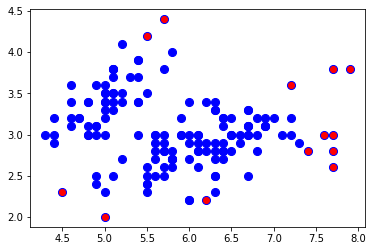

In [19]:
# 繪製全部數據
plt.scatter(df["sepal_length"], df["sepal_width"], color = "b", s = 65)
# 繪製異常值
plt.scatter(df.iloc[anomaly_index]['sepal_length'], df.iloc[anomaly_index]["sepal_width"], color = "r")

> 可以看到看起來也還不錯。

## 透過真實資料進行上述兩個模型的檢驗 (先忽略KNN)
- [ODDS](http://odds.cs.stonybrook.edu/#table1) - http (KDDCUP99) dataset
- 選擇這個資料是因為可以廣泛用於網路公司中。

In [20]:
import os

predir = './data'
os.listdir(predir)

['http.mat']

In [21]:
# !pip install mat73
# 為了 .mat檔案

In [22]:
import mat73

data = mat73.loadmat(os.path.join(predir, 'http.mat')) 
data

{'X': array([[-2.30258509,  5.37110304, 10.71610745],
        [-2.30258509,  5.08821343,  8.4180577 ],
        [-2.30258509,  5.46425544,  7.11322354],
        ...,
        [-2.30258509,  5.38495367,  8.19149075],
        [-2.30258509,  5.38952825,  7.11809724],
        [-2.30258509,  5.38952825,  7.00133669]]),
 'y': array([0., 0., 0., ..., 0., 0., 0.])}

In [23]:
data['X'].shape, data['y'].shape

((567498, 3), (567498,))

#### 看到已經都處理好，直接進行切分、建模即可。

In [24]:
## 原始資料

X = data['X']
y = data['y']

In [25]:
## 切分資料
from sklearn.model_selection import train_test_split

random_state = 222
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=222)

In [26]:
## 查看 y 的比例，可以概略看出切分是否合理
## 透過檢定是否有顯著差異

from scipy.stats import ttest_ind

alpha = 0.05
a, b = y_train, y_test
result = ttest_ind(a, b)

assert result.pvalue > alpha

In [27]:
## 沒有顯著差異

result.pvalue

0.3595578509731172

In [28]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

def precision_at_k(y_true, y_score, k, pos_label=1):
    from sklearn.utils import column_or_1d
    from sklearn.utils.multiclass import type_of_target
    
    y_true_type = type_of_target(y_true)
    if not (y_true_type == "binary"):
        raise ValueError("y_true must be a binary column.")
    
    # Makes this compatible with various array types
    y_true_arr = column_or_1d(y_true)
    y_score_arr = column_or_1d(y_score)
    
    y_true_arr = y_true_arr == pos_label
    
    desc_sort_order = np.argsort(y_score_arr)[::-1]
    y_true_sorted = y_true_arr[desc_sort_order]
    y_score_sorted = y_score_arr[desc_sort_order]
    
    true_positives = y_true_sorted[:k].sum()
    
    return true_positives / k

def get_metric(y_true, y_pred):
    return {
        'roc': roc_auc_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred), # 補f1-score比較好理解
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'acc': accuracy_score(y_true, y_pred),
        'precision_at_k': precision_at_k(y_true, y_pred, 5)
    }
    

### Isolation Forest

In [29]:
%%time
## 1. Isolation Forest

iso_forest = IsolationForest()
iso_forest.fit(x_train)
iso_pred = iso_forest.predict(x_train)

y_train_iso = np.where(iso_pred == 1, 0, 1)
y_train_iso

Wall time: 12.2 s


array([1, 0, 0, ..., 1, 0, 0])

In [30]:
## 孤立森林在訓練資料上的表現

get_metric(y_train, y_train_iso)

{'roc': 0.9476621112445481,
 'f1_score': 0.0691137912952281,
 'precision': 0.03579381891260659,
 'recall': 1.0,
 'acc': 0.8957294008003948,
 'precision_at_k': 0.2}

In [31]:
%%time

## 在測試資料上預測

y_test_iso = iso_forest.predict(x_test)
y_test_iso = np.where(y_test_iso == 1,  0, 1)
y_test_iso

Wall time: 1.06 s


array([0, 0, 0, ..., 0, 0, 0])

In [32]:
## 在測試資料上的評估

get_metric(y_test, y_test_iso)

{'roc': 0.9477670040342558,
 'f1_score': 0.07344632768361582,
 'precision': 0.03812316715542522,
 'recall': 1.0,
 'acc': 0.8959647577092511,
 'precision_at_k': 0.0}

> 看起來效果都還不錯！

---

2023-02-11
- recall 是不錯，recall代表的意思是所有`正樣本(異常)`被抓出來的比例。
- precision很差，precision代表的意思是所有預測為正樣本的資料中，真正是正樣本的比例。
- 所以說這個模型判定為異常的機率有點太高，很容易有 `alert hell` 的狀況。

### LOF

In [33]:
%%time

## LOF 模型訓練以及評估

lof = LocalOutlierFactor(n_neighbors=100,novelty=True)
lof.fit(x_train)

y_train_lof = lof.predict(x_train)
y_train_lof = np.where(y_train_lof == 1, 0, 1)
get_metric(y_train, y_train_lof)

Wall time: 46.6 s


{'roc': 0.5168555073367329,
 'f1_score': 0.018251767021562136,
 'precision': 0.01108695652173913,
 'recall': 0.051593323216995446,
 'acc': 0.9785158238505095,
 'precision_at_k': 0.0}

In [34]:
%%time

y_test_lof = lof.predict(x_test)
y_test_lof = np.where(y_test_lof == 1,  0, 1)
get_metric(y_test, y_test_lof)

Wall time: 2.56 s


{'roc': 0.5272654049106734,
 'f1_score': 0.02666666666666667,
 'precision': 0.01633045148895293,
 'recall': 0.07264957264957266,
 'acc': 0.9781321585903083,
 'precision_at_k': 0.0}

LOF看起來是整體都爛。

### One-Class SVM


In [35]:
from sklearn.svm import OneClassSVM

In [36]:
# %%time
## 太久了先跳過

# ## SVM

# svm = OneClassSVM()
# svm.fit(x_train)

# y_train_svm = svm.predict(x_train)

In [37]:
# ## 轉換

# y_train_svm[:10]

## 測試如何預估異常分數
- 參考了[Google文章: Unsupervised and semi-supervised anomaly detection with data-centric ML](https://ai.googleblog.com/2023/02/unsupervised-and-semi-supervised.html)，其中第一個SSR方法，透過不同模型的判斷分數 ensemble，來得到 refined data，再去訓練 one-class classifier(OCC) 來判斷。
- 雖然我沒有用OCC來去前面的ensemble，先用以上已經train好了模型來模擬概念。
    - 透過多個模型去預測是否異常分數來ensemble
    - 得到refined data
    - 在OCC上訓練
    
---

2023-02-11

In [49]:
## 1.透過多個模型去預測是否異常分數來ensemble

## Isolation forest: decision function可以預測輸入樣本的異常分數。越低，越不正常。負分代表異常值，正分代表異常值。
normal_scores_iso = iso_forest.decision_function(x_train[:10])
print(normal_scores_iso)

## LOF: decision function可以預測輸入樣本的異常分數。越低，越不正常。負分代表異常值，正分代表異常值。
normal_scores_lof = lof.decision_function(x_train[:10])
print(normal_scores_lof)

[-0.0328553   0.10398069  0.07780913  0.06329257  0.10870586  0.10234508
  0.10339006  0.09006965  0.0824826   0.10903927]
[ 4.81508137e-01  4.76293866e-01  5.12231924e-01  4.68347353e-01
  4.22082605e-01  4.83249803e-01 -1.43949628e+07  5.10178639e-01
  5.14850829e-01  4.87969878e-01]


In [53]:
## 2.得到refined data

## 兩者分數加起來/2，仍然是正數就代表是normal(其實除不除到是無所謂)
refined_data_index = np.where((normal_scores_iso + normal_scores_lof) > 0)[0]
print(refined_data_index)

[0 1 2 3 4 5 7 8 9]


In [56]:
## 3.在OCC上訓練

svm = OneClassSVM()
svm.fit(x_train[refined_data_index])
svm.predict(x_train[:10])

array([-1,  1, -1, -1, -1,  1, -1,  1,  1,  1], dtype=int64)

> 以上大概是概念演示。